# Universal Sparse AutoEncoders (USAE)

### Models and Hooks

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

# 1. Configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 128
# We need to know the dimensions to build the Autoencoder later
RESNET_DIM = 512   # ResNet18 layer4 outputs 512 channels
VIT_DIM = 768      # ViT-B outputs 768 dimensions

# 2. Data Loading (CIFAR-10)
# We use standard ImageNet stats since these models are pre-trained
transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize because ViT expects 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

print("Downloading CIFAR-10...")
# We use a small batch size to fit in memory
dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# 3. Load Models
print("Loading Pre-trained Models...")

# Model A: ResNet-18 (CNN)
resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1).to(device)
resnet.eval() # Freeze

# Model B: ViT-B-16 (Transformer)
vit = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1).to(device)
vit.eval() # Freeze

# 4. The "Hooking" Mechanism
# This dictionary will store the activations captured during the forward pass
activations = {}

def get_activation(name):
    def hook(model, input, output):
        # Flatten the output to (Batch, Dim)
        # For ResNet: (B, 512, 7, 7) -> Average Pool -> (B, 512)
        if len(output.shape) == 4:
            activations[name] = output.mean(dim=[2, 3]).detach()
        # For ViT: (B, 197, 768) -> Take [CLS] token (index 0) -> (B, 768)
        elif len(output.shape) == 3:
            activations[name] = output[:, 0, :].detach()
        else:
            activations[name] = output.detach()
    return hook

# Attach hooks to specific meaningful layers
# ResNet: Layer 4 is the high-level semantic layer before the classifier
resnet.layer4.register_forward_hook(get_activation('resnet'))

# ViT: The last encoder block before the head
vit.encoder.layers.encoder_layer_11.register_forward_hook(get_activation('vit'))

print("✅ Models loaded and Hooks attached!")
print(f"   - ResNet Hook: 'layer4' (Expected Dim: {RESNET_DIM})")
print(f"   - ViT Hook: 'encoder_layer_11' (Expected Dim: {VIT_DIM})")

100%|██████████| 170M/170M [00:01<00:00, 106MB/s]  


Loading Pre-trained Models...


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 182MB/s]
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 180MB/s]  


✅ Models loaded and Hooks attached!
   - ResNet Hook: 'layer4' (Expected Dim: 512)
   - ViT Hook: 'encoder_layer_11' (Expected Dim: 768)


In [2]:
# Quick test pass
try:
    dummy_img, _ = next(iter(dataloader))
    dummy_img = dummy_img.to(device)
    
    # Forward pass to trigger hooks
    with torch.no_grad():
        _ = resnet(dummy_img)
        _ = vit(dummy_img)
        
    print("Hook Verification:")
    print(f"   - ResNet Activations: {activations['resnet'].shape} (Should be [128, 512])")
    print(f"   - ViT Activations:    {activations['vit'].shape}    (Should be [128, 768])")
    
except Exception as e:
    print(f"Error in hooks: {e}")

Hook Verification:
   - ResNet Activations: torch.Size([128, 512]) (Should be [128, 512])
   - ViT Activations:    torch.Size([128, 768])    (Should be [128, 768])


## USAE Class

In [3]:
# --- STEP 2.5: COMPUTE NORMALIZATION STATS ---
# We need to standardize activations so one model doesn't dominate the loss.

def get_model_stats(loader, models, num_batches=20):
    print("📊 Computing activation statistics for normalization...")
    stats = {}
    
    # storage
    all_acts = {name: [] for name in models.keys()}
    
    for i, (images, _) in enumerate(loader):
        if i >= num_batches: break
        images = images.to(device)
        
        with torch.no_grad():
            _ = models['resnet'](images)
            all_acts['resnet'].append(activations['resnet'].clone())
            
            _ = models['vit'](images)
            all_acts['vit'].append(activations['vit'].clone())
            
    # Compute Mean/Std
    for name, acts_list in all_acts.items():
        # Concatenate all batches: (N_total, Dim)
        full_acts = torch.cat(acts_list, dim=0)
        mu = full_acts.mean(dim=0)
        std = full_acts.std(dim=0) + 1e-6 # Avoid div by zero
        stats[name] = {'mu': mu, 'std': std}
        print(f"   - {name}: Mean={mu.mean():.4f}, Std={std.mean():.4f}")
        
    return stats

# Run the stats computation
model_dict = {'resnet': resnet, 'vit': vit}
norm_stats = get_model_stats(dataloader, model_dict)

📊 Computing activation statistics for normalization...
   - resnet: Mean=0.7559, Std=0.6758
   - vit: Mean=-0.0120, Std=0.2981


In [4]:
class UniversalTopK_SAE(nn.Module):
    def __init__(self, input_dims, latent_dim=2048, k=32):
        super().__init__()
        self.latent_dim = latent_dim
        self.k = k
        self.models = list(input_dims.keys())
        
        # Encoder: Model Dimension -> Latent Dimension
        self.encoders = nn.ModuleDict({
            name: nn.Linear(dim, latent_dim) for name, dim in input_dims.items()
        })
        
        # Decoder: Latent Dimension -> Model Dimension
        self.decoders = nn.ModuleDict({
            name: nn.Linear(latent_dim, dim, bias=False) for name, dim in input_dims.items()
        })
        
        # Biases (As per Manual Eq b and c)
        self.b_pre = nn.ParameterDict({
            name: nn.Parameter(torch.zeros(dim)) for name, dim in input_dims.items()
        })
        self.b_enc = nn.ParameterDict({ # Bias added BEFORE TopK
            name: nn.Parameter(torch.zeros(latent_dim)) for name, dim in input_dims.items()
        })
        self.b_dec = nn.ParameterDict({
            name: nn.Parameter(torch.zeros(dim)) for name, dim in input_dims.items()
        })

    def encode(self, x, model_name):
        # Manual Eq (b): Z = TopK(W_enc(x - b_pre))
        # Note: Some papers add bias after W_enc. We'll add b_enc to be safe.
        pre_act = self.encoders[model_name](x - self.b_pre[model_name]) + self.b_enc[model_name]
        
        # TopK Activation
        topk_vals, topk_inds = torch.topk(pre_act, self.k, dim=-1)
        z = torch.zeros_like(pre_act)
        z.scatter_(-1, topk_inds, topk_vals)
        return z

    def decode(self, z, target_model_name):
        # Manual Eq (c): x_hat = Z D + b_dec
        return self.decoders[target_model_name](z) + self.b_dec[target_model_name]

    def forward(self, x, source_model):
        z = self.encode(x, source_model)
        recons = {}
        for target_name in self.models:
            recons[target_name] = self.decode(z, target_name)
        return z, recons

In [5]:
import torch.optim as optim
import random

# Configuration
EPOCHS = 15  # Increased slightly to ensure convergence
LR = 1e-3    # Standard for SAEs
LATENT_DIM = 2048 
K_SPARSITY = 32

input_dimensions = {'resnet': RESNET_DIM, 'vit': VIT_DIM} 
usae = UniversalTopK_SAE(input_dimensions, latent_dim=LATENT_DIM, k=K_SPARSITY).to(device)
optimizer = optim.Adam(usae.parameters(), lr=LR)

print(f"Training USAE on {list(input_dimensions.keys())}...")

for epoch in range(EPOCHS):
    total_loss = 0
    steps = 0
    
    for images, _ in dataloader:
        images = images.to(device)
        
        # 1. Capture Activations & Normalize
        ground_truth = {}
        with torch.no_grad():
            _ = resnet(images)
            raw_res = activations['resnet']
            # Normalize: (x - mu) / std
            ground_truth['resnet'] = (raw_res - norm_stats['resnet']['mu']) / norm_stats['resnet']['std']
            
            _ = vit(images)
            raw_vit = activations['vit']
            ground_truth['vit'] = (raw_vit - norm_stats['vit']['mu']) / norm_stats['vit']['std']
        
        # 2. Universal Step
        # Pick random source
        source_name = random.choice(['resnet', 'vit'])
        input_act = ground_truth[source_name] # This is already normalized
        
        # Forward
        z, recons = usae(input_act, source_name)
        
        # 3. Loss: Sum of Reconstruction Errors (Manual Eq d)
        # We compute loss in the NORMALIZED space to ensure fair weighting
        loss = 0
        for target_name, target_act in ground_truth.items():
            loss += nn.functional.mse_loss(recons[target_name], target_act)
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        steps += 1
        
    print(f"   Epoch {epoch+1}/{EPOCHS} | Universal Loss: {total_loss/steps:.6f}")

print("✅ Training Complete.")

Training USAE on ['resnet', 'vit']...
   Epoch 1/15 | Universal Loss: 1.517163
   Epoch 2/15 | Universal Loss: 1.168113
   Epoch 3/15 | Universal Loss: 1.059774
   Epoch 4/15 | Universal Loss: 1.001398
   Epoch 5/15 | Universal Loss: 0.955919
   Epoch 6/15 | Universal Loss: 0.921793
   Epoch 7/15 | Universal Loss: 0.895267
   Epoch 8/15 | Universal Loss: 0.878653
   Epoch 9/15 | Universal Loss: 0.861806
   Epoch 10/15 | Universal Loss: 0.846670
   Epoch 11/15 | Universal Loss: 0.831008
   Epoch 12/15 | Universal Loss: 0.818459
   Epoch 13/15 | Universal Loss: 0.805441
   Epoch 14/15 | Universal Loss: 0.794736
   Epoch 15/15 | Universal Loss: 0.783360
✅ Training Complete.


📊 Running Universality Analysis...


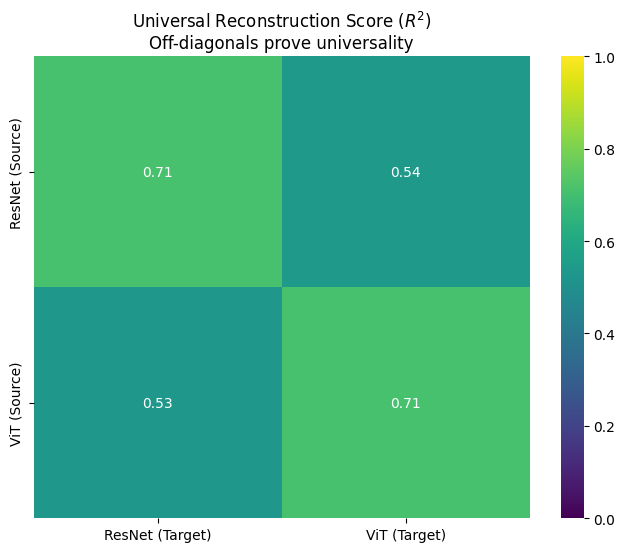

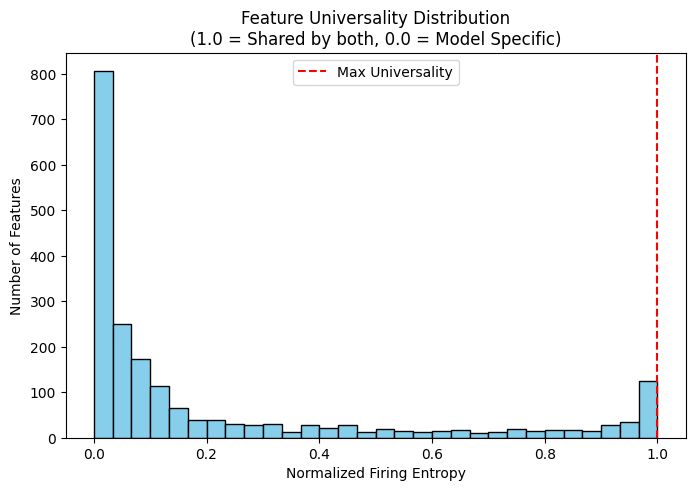

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def analyze_usae(loader, usae, stats):
    print("📊 Running Universality Analysis...")
    
    # Metrics Storage
    # R2 Accumulators: [Source, Target]
    # 0: ResNet, 1: ViT
    ss_res = np.zeros((2, 2)) # Residual Sum of Squares
    ss_tot = np.zeros((2, 2)) # Total Sum of Squares
    
    # Entropy Storage: Sum of Z activations for each model [Feature_Dim, Model_Index]
    z_sums = torch.zeros(usae.latent_dim, 2).to(device)
    
    usae.eval()
    with torch.no_grad():
        for images, _ in loader:
            images = images.to(device)
            
            # 1. Get Ground Truth & Normalize
            # Note: We use the SAME stats computed earlier
            acts = {}
            _ = resnet(images)
            acts['resnet'] = (activations['resnet'] - stats['resnet']['mu']) / stats['resnet']['std']
            
            _ = vit(images)
            acts['vit'] = (activations['vit'] - stats['vit']['mu']) / stats['vit']['std']
            
            # 2. Cross-Model Reconstruction Loop
            model_names = ['resnet', 'vit']
            
            for i, src_name in enumerate(model_names):
                # Encode from Source
                z = usae.encode(acts[src_name], src_name)
                
                # Accumulate activity for Entropy (Sum of magnitudes)
                z_sums[:, i] += z.sum(dim=0)
                
                for j, tgt_name in enumerate(model_names):
                    # Decode to Target
                    recon = usae.decode(z, tgt_name)
                    target = acts[tgt_name]
                    
                    # Compute R2 components
                    # SS_res = sum((y - y_hat)^2)
                    # SS_tot = sum((y - y_mean)^2) -> Since normalized, mean is ~0, so sum(y^2)
                    ss_res[i, j] += torch.sum((target - recon) ** 2).item()
                    ss_tot[i, j] += torch.sum(target ** 2).item()

    # --- A. Compute R2 Matrix ---
    r2_matrix = 1 - (ss_res / ss_tot)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(r2_matrix, annot=True, cmap='viridis', vmin=0, vmax=1, fmt='.2f',
                xticklabels=['ResNet (Target)', 'ViT (Target)'],
                yticklabels=['ResNet (Source)', 'ViT (Source)'])
    plt.title("Universal Reconstruction Score ($R^2$)\nOff-diagonals prove universality")
    plt.show()
    
    # --- B. Compute Firing Entropy ---
    # P_k^(i) = activation_sum_i / total_activation_sum
    # Add epsilon to avoid log(0)
    total_activity = z_sums.sum(dim=1, keepdim=True) + 1e-9
    probs = z_sums / total_activity
    
    # Entropy H = -Sum(p * log(p)) / log(M)
    # M = 2 (Number of models)
    entropy = -torch.sum(probs * torch.log(probs + 1e-9), dim=1) / np.log(2)
    entropy = entropy.cpu().numpy()
    
    # Plot Histogram
    plt.figure(figsize=(8, 5))
    plt.hist(entropy, bins=30, color='skyblue', edgecolor='black')
    plt.axvline(x=1.0, color='red', linestyle='--', label='Max Universality')
    plt.xlabel("Normalized Firing Entropy")
    plt.ylabel("Number of Features")
    plt.title("Feature Universality Distribution\n(1.0 = Shared by both, 0.0 = Model Specific)")
    plt.legend()
    plt.show()
    
    return r2_matrix, entropy

r2_scores, entropies = analyze_usae(dataloader, usae, norm_stats)

🎨 Generating Visions for Universal Features: [1692 1721  995]


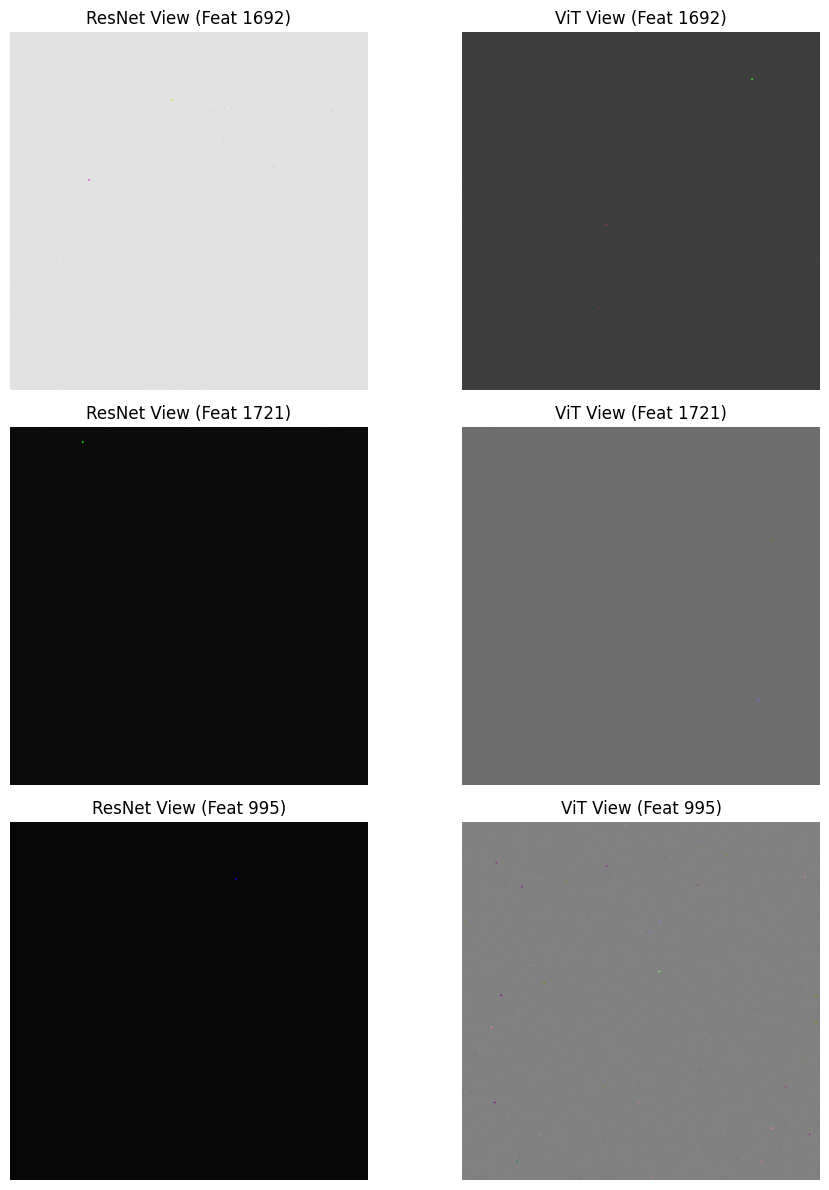

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Select Features ---
# We use the entropy calculated earlier to pick Universal features
universal_indices = np.where(entropies > 0.9)[0]
if len(universal_indices) < 3:
    print("Warning: Few universal features found. Picking random high-entropy ones.")
    target_features = np.argsort(entropies)[-3:] # Top 3 entropy
else:
    target_features = np.random.choice(universal_indices, 3, replace=False)

print(f"🎨 Generating Visions for Universal Features: {target_features}")

# --- 2. Improved Optimization Function ---
def generate_robust_consensus(model, model_name, feature_idx, usae, stats, steps=250):
    # Initialize with random noise
    img = torch.randn(1, 3, 224, 224, device=device, requires_grad=True)
    
    # Use a slightly more aggressive optimizer for viz
    opt_img = torch.optim.Adam([img], lr=0.05)
    
    for _ in range(steps):
        opt_img.zero_grad()
        
        # Forward pass through FROZEN model
        _ = model(img)
        raw = activations[model_name]
        norm = (raw - stats[model_name]['mu']) / stats[model_name]['std']
        
        # --- CRITICAL FIX: Access Pre-TopK Activation ---
        # We manually run the linear layer to get gradients even if feature is inactive
        encoder = usae.encoders[model_name]
        b_pre = usae.b_pre[model_name]
        b_enc = usae.b_enc[model_name]
        
        # Calculate pre-activation (Linear step)
        pre_act = encoder(norm - b_pre) + b_enc
        
        # Maximize this specific neuron's potential
        target_val = pre_act[0, feature_idx]
        
        # Loss: Maximize activation + Regularization
        # L2 penalty keeps pixels from exploding to infinity
        loss = -target_val + 0.2 * torch.mean(img**2)
        
        loss.backward()
        opt_img.step()
        
    # Robust Un-normalization for Display
    # We map the specific min-max of the generated image to 0-1 range for visibility
    with torch.no_grad():
        vis = img[0].cpu().permute(1, 2, 0)
        # Auto-scale contrast
        vis = (vis - vis.min()) / (vis.max() - vis.min() + 1e-8)
        
    return vis

# --- 3. Run & Plot ---
fig, axes = plt.subplots(3, 2, figsize=(10, 12))

for row, feat_idx in enumerate(target_features):
    # ResNet View
    img_res = generate_robust_consensus(resnet, 'resnet', feat_idx, usae, norm_stats)
    axes[row, 0].imshow(img_res)
    axes[row, 0].set_title(f"ResNet View (Feat {feat_idx})")
    axes[row, 0].axis('off')
    
    # ViT View
    img_vit = generate_robust_consensus(vit, 'vit', feat_idx, usae, norm_stats)
    axes[row, 1].imshow(img_vit)
    axes[row, 1].set_title(f"ViT View (Feat {feat_idx})")
    axes[row, 1].axis('off')

plt.tight_layout()
plt.show()